In [1]:
import sys
import gymnasium
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

from building_energy_storage_simulation import BuildingSimulation, Environment

from observation_wrapper import ObservationWrapper
from helper import read_data, TEST_INDEX_START, TEST_INDEX_END

# Applying Reiforcement Learning Using Stable Baselines 3


In [2]:
NUM_FORECAST_STEPS = 8
RESULT_PATH = 'rl_example/'

os.makedirs(RESULT_PATH, exist_ok=True)

load, price, generation = read_data()
load_train = load[:TEST_INDEX_START]
price_train = price[:TEST_INDEX_START]
generation_train = generation[:TEST_INDEX_START]

# Create Training Environment
sim = BuildingSimulation(electricity_load_profile=load_train,
                         solar_generation_profile=generation_train,
                         electricity_price=price_train,
                         max_battery_charge_per_timestep=100,
                         battery_capacity=400)

env = Environment(sim, num_forecasting_steps=NUM_FORECAST_STEPS, max_timesteps=len(load_train)-NUM_FORECAST_STEPS)
# ObservationWrapper combines forecast of load and generation to one residual load forecast
env = ObservationWrapper(env, NUM_FORECAST_STEPS)
initial_obs, info = env.reset()
print(initial_obs)

[ 0.       9.89     9.08     8.22     8.57     8.93     9.2     10.71
  3.98309  5.005    4.133    4.322    4.546    3.767    3.97     4.059
  4.326  ]


In [3]:
# Wrap with Monitor() so a log of the training is saved 
env = Monitor(env, filename=RESULT_PATH)
# Warp with DummyVecEnc() so the observations and reward can be normalized using VecNormalize()
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

In [4]:
# Train :-)
model = PPO("MlpPolicy", env, verbose=1, gamma=0.95)
model.learn(total_timesteps=200000)
# Store the trained Model and environment stats (which are needed as we are standardizing the observations and reward using VecNormalize())
model.save(RESULT_PATH + 'model')
env.save(RESULT_PATH + 'env.pkl')

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1846 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1387         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036777142 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.708       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000247     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00348     |
|    std                  | 0.995        |
|    value_loss           | 0.234        |

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.37e+03     |
|    ep_rew_mean          | -4.85e+06    |
| time/                   |              |
|    fps                  | 1122         |
|    iterations           | 11           |
|    time_elapsed         | 20           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0056245844 |
|    clip_fraction        | 0.0404       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00556      |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00522     |
|    std                  | 0.941        |
|    value_loss           | 0.00499      |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.37e+03     |
|    ep_rew_mean          | -4.72e+06    |
| time/                   |              |
|    fps                  | 1006         |
|    iterations           | 20           |
|    time_elapsed         | 40           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0056182286 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0388      |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00686     |
|    std                  | 0.801        |
|    value_loss           | 0.00517      |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.37e+03    |
|    ep_rew_mean          | -4.58e+06   |
| time/                   |             |
|    fps                  | 979         |
|    iterations           | 29          |
|    time_elapsed         | 60          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.006090526 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0111     |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00702    |
|    std                  | 0.722       |
|    value_loss           | 0.00728     |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.37e+03    |
|    ep_rew_mean          | -4.47e+06   |
| time/                   |             |
|    fps                  | 963         |
|    iterations           | 38          |
|    time_elapsed         | 80          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.005639543 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.996      |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.011      |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00759    |
|    std                  | 0.655       |
|    value_loss           | 0.00563     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.37e+03    |
|    ep_rew_mean          | -4.37e+06   |
| time/                   |             |
|    fps                  | 930         |
|    iterations           | 47          |
|    time_elapsed         | 103         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.007721955 |
|    clip_fraction        | 0.086       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.919      |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0058      |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00828    |
|    std                  | 0.601       |
|    value_loss           | 0.00257     |
-----------------------------------------


KeyboardInterrupt: 

In [5]:
env.save(RESULT_PATH + 'env.pkl')

# Evaluation

<Axes: >

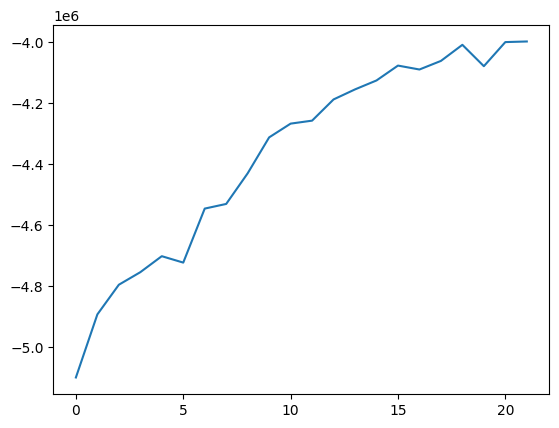

In [6]:
# Plot the training process
training_log = pd.read_csv(RESULT_PATH + 'monitor.csv', skiprows=1)
training_log['r'].plot()

In [7]:
load, price, generation = read_data()
load_eval = load[TEST_INDEX_START:]
price_eval = price[TEST_INDEX_START:]
generation_eval = generation[TEST_INDEX_START:]

num_eval_timesteps = TEST_INDEX_END - TEST_INDEX_START

eval_sim = BuildingSimulation(electricity_load_profile=load_eval,
                              solar_generation_profile=generation_eval,
                              electricity_price=price_eval,
                              max_battery_charge_per_timestep=100, 
                              battery_capacity=400)

eval_env = Environment(eval_sim, num_forecasting_steps=NUM_FORECAST_STEPS, max_timesteps=num_eval_timesteps)
eval_env = ObservationWrapper(eval_env, NUM_FORECAST_STEPS)
eval_env = DummyVecEnv([lambda: eval_env])
# It is important to load the environmental statistics here as we use a rolling mean calculation !
eval_env = VecNormalize.load(RESULT_PATH + 'env.pkl', eval_env)     

In [8]:
eval_env.training = False

actions, observations, electricity_consumption, price, rewards = ([], [], [], [], [])
done = False
obs = eval_env.reset()
while not done:
        action = model.predict(obs, deterministic=True)
        obs, r, done, info = eval_env.step([action[0][0]])

        actions.append(action[0][0][0])
        original_reward = eval_env.get_original_reward()[0]
        original_obs = eval_env.get_original_obs()[0]
        observations.append(original_obs)
        electricity_consumption.append(info[0]['electricity_consumption'])
        price.append(info[0]['electricity_price'])
        rewards.append(r)
        
trajectory = pd.DataFrame({
        'action': actions,
        'observations': observations,
        'electricity_consumption': electricity_consumption,
        'electricity_price': price,
        'reward': rewards
    })        

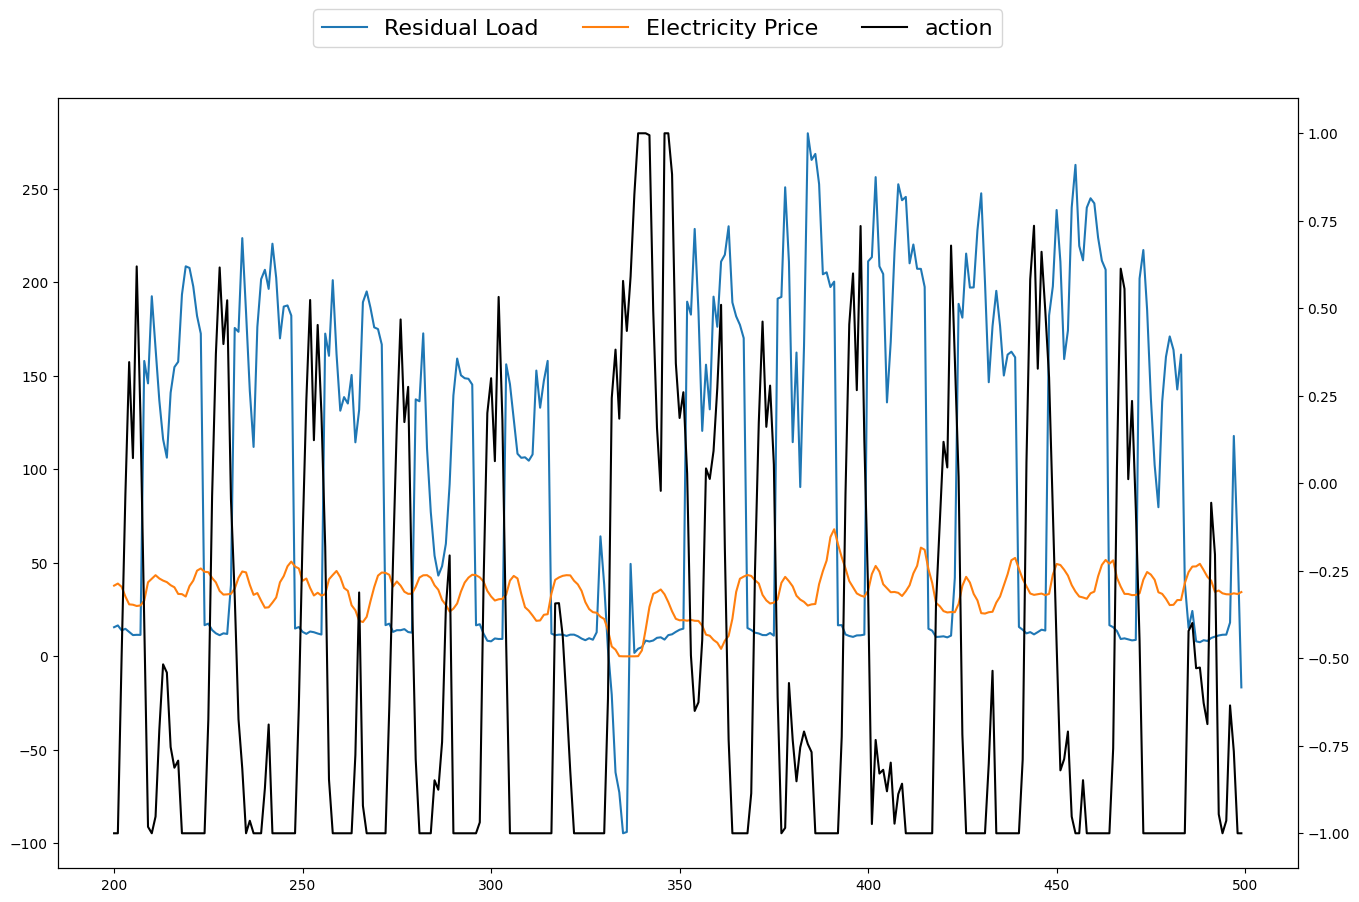

In [9]:
plot_data = trajectory[200:500]
observation_df = plot_data['observations'].apply(pd.Series)

plt.rcParams["figure.figsize"] = (16,10)

fig, ax = plt.subplots()
ax.plot(observation_df[1], label = 'Residual Load')
ax.plot(plot_data['electricity_price'], label = 'Electricity Price')

ax1 = ax.twinx()
ax1.plot(plot_data['action'], label = 'action', color = 'black')
fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5, prop={'size': 16})

# Compare to Baseline

In [10]:
eval_env.training = False

cost = []
done = False
obs = eval_env.reset()
while not done:
        action = model.predict(obs, deterministic=True)
        obs, r, done, info = eval_env.step([action[0][0]])
        cost.append(info[0]['electricity_consumption'] * info[0]['electricity_price'])

cost = sum(cost)

In [11]:
eval_env.training = False

baseline_cost = []
done = False
obs = eval_env.reset()
while not done:
        # Always taking noop as action. This is the electricity demand if there would be no battery
        action = [0]
        obs, r, done, info = eval_env.step(action)
        baseline_cost.append(info[0]['electricity_consumption'] * info[0]['electricity_price'])

baseline_cost = sum(baseline_cost)

In [12]:
# how much energy did we save by utilizing the battery?
1 - (cost / baseline_cost)

-0.0012597516984353962

In [13]:
baseline_cost

9588993.273488251

In [14]:
cost

9601073.024050813